In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

In [2]:
sites = pd.read_csv('data/PISCOSites.csv')
sites

,site,latitude,longitude,MPA_Name,mpa_type,site_status
0,PINOS,36.640454,-121.928734,Lovers Point - Julia Platt SMR,SMR,reference
1,SIREN,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference
2,CYPRESS_PT_DC,36.579645,-121.982468,Carmel Bay SMCA,SMCA,reference
3,LONE_TREE,36.566418,-121.970688,Carmel Bay SMCA,SMCA,reference
4,OTTER_PT_DC,36.636484,-121.921162,Lovers Point - Julia Platt SMR,SMR,reference
...,...,...,...,...,...,...
139,SCI_SAN_PEDRO_POINT_W,34.042250,-119.531600,Scorpion SMR,SMR,reference
140,SCI_POTATO_PASTURE_W,34.052233,-119.582533,Scorpion SMR,SMR,mpa
141,SCI_POTATO_PASTURE_W,34.052167,-119.582117,Scorpion SMR,SMR,mpa
142,SCI_SCORPION_ANCHORAGE,34.047983,-119.551400,Scorpion SMR,SMR,mpa


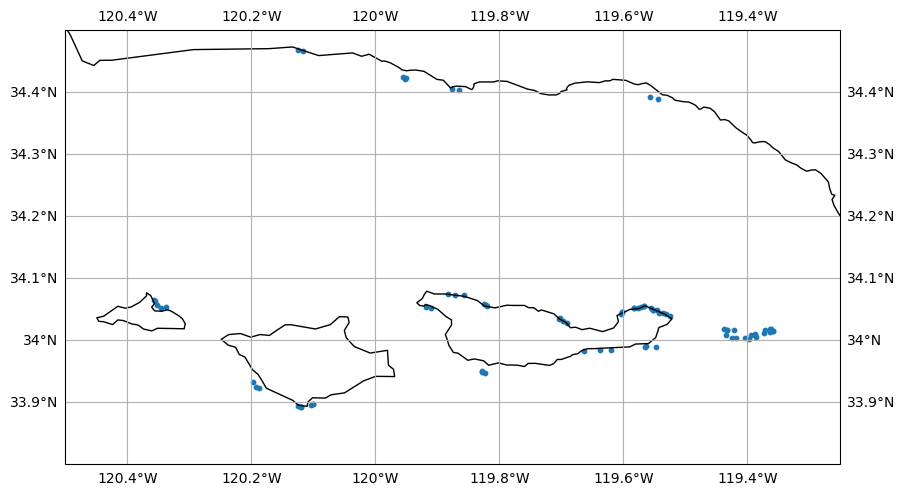

In [3]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-120.5, -119.25, 33.8, 34.5], crs=ccrs.PlateCarree())
ax.scatter(sites['longitude'], sites['latitude'], s=10)

In [4]:
kelp = pd.read_csv('data/PISCO_kelpdata.csv')
kelp

,method,year,month,day,site,zone,transect,classcode,count,size,depth,latitude,longitude,MPA_Name,mpa_type,site_status
0,SBTL_SWATH_PISCO,2024,7,4,PINOS,INNER,2,LAMSETAD,4,NaN,4.9,36.640454,-121.928734,Lovers Point - Julia Platt SMR,SMR,reference
1,SBTL_SWATH_PISCO,2024,7,4,PINOS,INNER,2,NERLUE,1,NaN,4.9,36.640454,-121.928734,Lovers Point - Julia Platt SMR,SMR,reference
2,SBTL_SWATH_PISCO,2024,7,4,SIREN,INNER,1,LAMREC,1,NaN,5.3,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference
3,SBTL_SWATH_PISCO,2024,7,4,SIREN,INNER,1,MACPYRAD,1,1.0,5.3,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference
4,SBTL_SWATH_PISCO,2024,7,4,SIREN,INNER,1,MACPYRAD,3,2.0,5.3,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,1,11.0,12.2,34.047983,-119.551400,Scorpion SMR,SMR,mpa
4498,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,1,15.0,12.2,34.047983,-119.551400,Scorpion SMR,SMR,mpa
4499,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,1,15.0,12.2,34.047983,-119.551400,Scorpion SMR,SMR,mpa
4500,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,STEOSMAD,2,NaN,11.3,34.047983,-119.551400,Scorpion SMR,SMR,mpa


In [5]:
kelp['date'] = pd.to_datetime(kelp[['year', 'month', 'day']])

In [6]:
kelp

,method,year,month,day,site,zone,transect,classcode,count,size,depth,latitude,longitude,MPA_Name,mpa_type,site_status,date
0,SBTL_SWATH_PISCO,2024,7,4,PINOS,INNER,2,LAMSETAD,4,NaN,4.9,36.640454,-121.928734,Lovers Point - Julia Platt SMR,SMR,reference,2024-07-04
1,SBTL_SWATH_PISCO,2024,7,4,PINOS,INNER,2,NERLUE,1,NaN,4.9,36.640454,-121.928734,Lovers Point - Julia Platt SMR,SMR,reference,2024-07-04
2,SBTL_SWATH_PISCO,2024,7,4,SIREN,INNER,1,LAMREC,1,NaN,5.3,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference,2024-07-04
3,SBTL_SWATH_PISCO,2024,7,4,SIREN,INNER,1,MACPYRAD,1,1.0,5.3,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference,2024-07-04
4,SBTL_SWATH_PISCO,2024,7,4,SIREN,INNER,1,MACPYRAD,3,2.0,5.3,36.630733,-121.918590,Lovers Point - Julia Platt SMR,SMR,reference,2024-07-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,1,11.0,12.2,34.047983,-119.551400,Scorpion SMR,SMR,mpa,2024-11-01
4498,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,1,15.0,12.2,34.047983,-119.551400,Scorpion SMR,SMR,mpa,2024-11-01
4499,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,1,15.0,12.2,34.047983,-119.551400,Scorpion SMR,SMR,mpa,2024-11-01
4500,SBTL_SWATH_PISCO,2024,11,1,SCI_SCORPION_ANCHORAGE,OUTER,2,STEOSMAD,2,NaN,11.3,34.047983,-119.551400,Scorpion SMR,SMR,mpa,2024-11-01


In [7]:
kelp = kelp.drop(columns=['year', 'month', 'day'])

In [8]:
newOrder = ['date', 'latitude', 'longitude', 'depth', 'method', 'site', 'zone', 'transect', 'classcode', 'count', 'size', 'MPA_Name', 'mpa_type', 'site_status']
kelp = kelp[newOrder]

In [9]:
piscoDates = kelp['date'].unique()

In [10]:
piscoDates

<DatetimeArray>
['2024-07-04 00:00:00', '2024-07-09 00:00:00', '2024-07-10 00:00:00',
 '2024-07-11 00:00:00', '2024-07-19 00:00:00', '2024-07-22 00:00:00',
 '2024-07-24 00:00:00', '2024-07-26 00:00:00', '2024-07-30 00:00:00',
 '2024-07-31 00:00:00', '2024-08-01 00:00:00', '2024-08-02 00:00:00',
 '2024-08-06 00:00:00', '2024-08-08 00:00:00', '2024-08-09 00:00:00',
 '2024-08-14 00:00:00', '2024-08-20 00:00:00', '2024-08-21 00:00:00',
 '2024-08-22 00:00:00', '2024-08-23 00:00:00', '2024-08-24 00:00:00',
 '2024-09-05 00:00:00', '2024-09-10 00:00:00', '2024-09-12 00:00:00',
 '2024-09-17 00:00:00', '2024-09-18 00:00:00', '2024-09-19 00:00:00',
 '2024-09-20 00:00:00', '2024-09-26 00:00:00', '2024-10-01 00:00:00',
 '2024-10-02 00:00:00', '2024-10-03 00:00:00', '2024-10-08 00:00:00',
 '2024-10-11 00:00:00', '2024-10-14 00:00:00', '2024-10-21 00:00:00',
 '2024-10-22 00:00:00', '2024-10-24 00:00:00', '2024-10-25 00:00:00',
 '2024-06-24 00:00:00', '2024-06-25 00:00:00', '2024-06-26 00:00:00',
 '20

In [11]:
kelpCounts = kelp.groupby(by=['date', 'site', 'zone', 'transect', 'classcode'])['count'].sum().reset_index()

In [12]:
kelpCounts

,date,site,zone,transect,classcode,count
0,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBAD,10
1,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBADSUB,68
2,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,LAMFAR,250
3,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,MACPYRAD,28
4,2024-06-24,ANACAPA_MIDDLE_ISLE_W,INNER,1,EISARBAD,1
...,...,...,...,...,...,...
1639,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,1,MACPYRAD,134
1640,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,1,STEOSMAD,16
1641,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,LAMFAR,44
1642,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,82


In [13]:
kelpCounts = kelpCounts.merge(sites, how='left', on='site')

In [14]:
kelpCounts

,date,site,zone,transect,classcode,count,latitude,longitude,MPA_Name,mpa_type,site_status
0,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBAD,10,34.016667,-119.361667,Anacapa Island SMR,SMR,mpa
1,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBAD,10,34.017033,-119.361133,Anacapa Island SMR,SMR,mpa
2,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBADSUB,68,34.016667,-119.361667,Anacapa Island SMR,SMR,mpa
3,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBADSUB,68,34.017033,-119.361133,Anacapa Island SMR,SMR,mpa
4,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,LAMFAR,250,34.016667,-119.361667,Anacapa Island SMR,SMR,mpa
...,...,...,...,...,...,...,...,...,...,...,...
1897,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,LAMFAR,44,34.047983,-119.551400,Scorpion SMR,SMR,mpa
1898,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,82,34.047983,-119.551400,Scorpion SMR,SMR,mpa
1899,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,82,34.047983,-119.551400,Scorpion SMR,SMR,mpa
1900,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,STEOSMAD,4,34.047983,-119.551400,Scorpion SMR,SMR,mpa


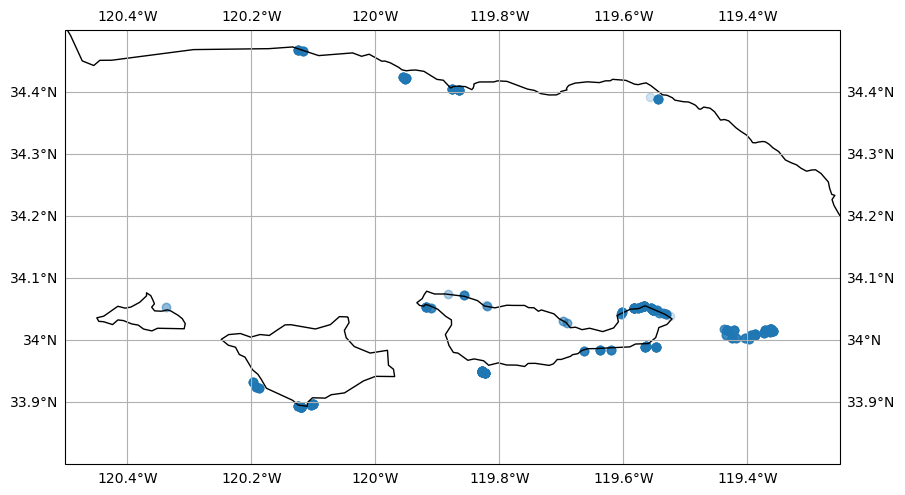

In [15]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-120.5, -119.25, 33.8, 34.5], crs=ccrs.PlateCarree())
ax.scatter(kelpCounts['longitude'], kelpCounts['latitude'], alpha=0.2)

In [34]:
kelpCountsWide = kelpCounts.groupby(['date', 'site', 'zone', 'transect', 'classcode']).size().unstack()
channel_islands_kelpCountsWide = channel_islands_kelpCounts.groupby(['date', 'site', 'zone', 'transect', 'classcode']).size().unstack()

In [30]:
min_lat = 33.8
max_lat = 34.5
min_lon = -120.5
max_lon = -119.25
channel_islands_mask = (kelpCounts['latitude'] >= min_lat) & \
                       (kelpCounts['latitude'] <= max_lat) & \
                       (kelpCounts['longitude'] >= min_lon) & \
                       (kelpCounts['longitude'] <= max_lon)
channel_islands_kelpCounts = kelpCounts[channel_islands_mask]
channel_islands_kelpCounts

,date,site,zone,transect,classcode,count,latitude,longitude,MPA_Name,mpa_type,site_status
0,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBAD,10,34.016667,-119.361667,Anacapa Island SMR,SMR,mpa
1,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBAD,10,34.017033,-119.361133,Anacapa Island SMR,SMR,mpa
2,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBADSUB,68,34.016667,-119.361667,Anacapa Island SMR,SMR,mpa
3,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,EISARBADSUB,68,34.017033,-119.361133,Anacapa Island SMR,SMR,mpa
4,2024-06-24,ANACAPA_EAST_ISLE_E,INNER,1,LAMFAR,250,34.016667,-119.361667,Anacapa Island SMR,SMR,mpa
...,...,...,...,...,...,...,...,...,...,...,...
1897,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,LAMFAR,44,34.047983,-119.551400,Scorpion SMR,SMR,mpa
1898,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,82,34.047983,-119.551400,Scorpion SMR,SMR,mpa
1899,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,MACPYRAD,82,34.047983,-119.551400,Scorpion SMR,SMR,mpa
1900,2024-11-01,SCI_SCORPION_ANCHORAGE,OUTER,2,STEOSMAD,4,34.047983,-119.551400,Scorpion SMR,SMR,mpa


In [17]:
kelpCounts

classcode                                         ALAMAR  COSCOS  EISARBAD  \
date       site                   zone  transect                             
2024-06-24 ANACAPA_EAST_ISLE_E    INNER 1            NaN     NaN       2.0   
           ANACAPA_MIDDLE_ISLE_W  INNER 1            NaN     NaN       1.0   
                                        2            NaN     NaN       NaN   
2024-06-25 ANACAPA_EAST_ISLE_E    INNER 2            NaN     NaN       2.0   
                                  OUTER 1            NaN     NaN       2.0   
...                                                  ...     ...       ...   
2024-11-01 SCI_SCORPION_ANCHORAGE INNER 2            NaN     NaN       NaN   
                                  MID   1            NaN     NaN       NaN   
                                        2            NaN     NaN       NaN   
                                  OUTER 1            NaN     NaN       NaN   
                                        2            NaN     NaN       NaN   

classcode                                         EISARBADSUB  LAMFAR  LAMREC  \
date       site                   zone  transect                                
2024-06-24 ANACAPA_EAST_ISLE_E    INNER 1                 2.0     2.0     NaN   
           ANACAPA_MIDDLE_ISLE_W  INNER 1                 1.0     1.0     NaN   
                                        2                 1.0     1.0     NaN   
2024-06-25 ANACAPA_EAST_ISLE_E    INNER 2                 2.0     2.0     NaN   
                                  OUTER 1                 2.0     2.0     NaN   
...                                                       ...     ...     ...   
2024-11-01 SCI_SCORPION_ANCHORAGE INNER 2                 2.0     2.0     NaN   
                                  MID   1                 NaN     2.0     NaN   
                                        2                 2.0     2.0     NaN   
                                  OUTER 1                 2.0     2.0     NaN   
                                        2                 NaN     2.0     NaN   

classcode                                         LAMSETAD  LAMSETADSUB  \
date       site                   zone  transect                          
2024-06-24 ANACAPA_EAST_ISLE_E    INNER 1              NaN          NaN   
           ANACAPA_MIDDLE_ISLE_W  INNER 1              NaN          NaN   
                                        2              NaN          NaN   
2024-06-25 ANACAPA_EAST_ISLE_E    INNER 2              NaN          NaN   
                                  OUTER 1              NaN          NaN   
...                                                    ...          ...   
2024-11-01 SCI_SCORPION_ANCHORAGE INNER 2              NaN          NaN   
                                  MID   1              NaN          NaN   
                                        2              NaN          NaN   
                                  OUTER 1              NaN          NaN   
                                        2              NaN          NaN   

classcode                                         LAMSETJUV  MACPYRAD  ...  \
date       site                   zone  transect                       ...   
2024-06-24 ANACAPA_EAST_ISLE_E    INNER 1               NaN       2.0  ...   
           ANACAPA_MIDDLE_ISLE_W  INNER 1               NaN       1.0  ...   
                                        2               NaN       1.0  ...   
2024-06-25 ANACAPA_EAST_ISLE_E    INNER 2               NaN       2.0  ...   
                                  OUTER 1               NaN       2.0  ...   
...                                                     ...       ...  ...   
2024-11-01 SCI_SCORPION_ANCHORAGE INNER 2               NaN       2.0  ...   
                                  MID   1               NaN       2.0  ...   
                                        2               NaN       2.0  ...   
                                  OUTER 1               NaN       2.0  ...   
                   

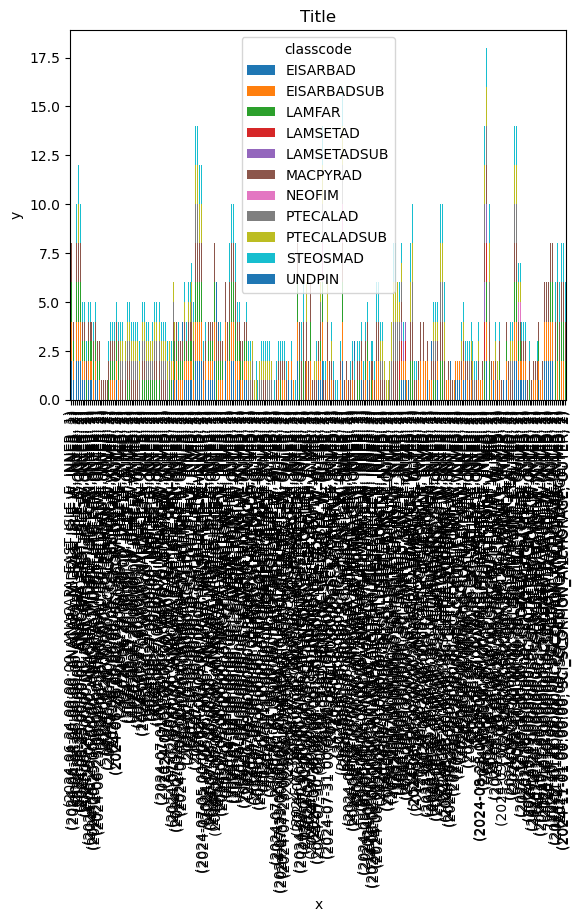

In [35]:
ax = channel_islands_kelpCountsWide.plot(kind='bar', stacked=True, title='Title')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

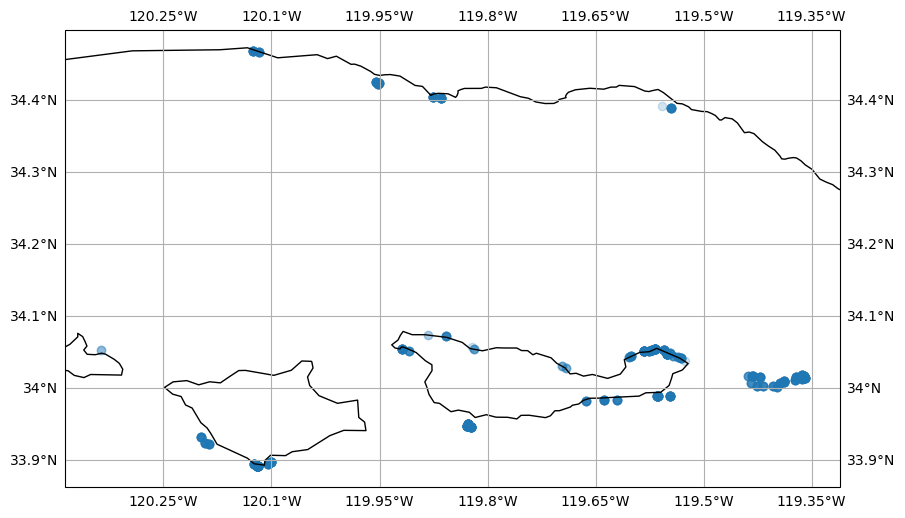

In [31]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True)
ax.coastlines()
# ax.set_extent([-120.5, -119.25, 33.8, 34.5], crs=ccrs.PlateCarree())
ax.scatter(channel_islands_kelpCounts['longitude'], channel_islands_kelpCounts['latitude'], alpha=0.2)

In [36]:
channel_islands_kelpCounts['site'].unique()

array(['ANACAPA_EAST_ISLE_E', 'ANACAPA_MIDDLE_ISLE_W',
       'ANACAPA_EAST_ISLE_W', 'ANACAPA_MIDDLE_ISLE_CEN', 'SCI_PELICAN_E',
       'SCI_SCORPION_W', 'IV_REEF_E', 'IV_REEF_W', 'NAPLES_CEN',
       'NAPLES_E', 'NAPLES_W', 'ARROYO_QUEMADO_W',
       'ANACAPA_EAST_ISLE_CEN', 'ANACAPA_WEST_ISLE_E', 'SCI_FORNEY_W',
       'SCI_GULL_ISLE_E', 'SCI_GULL_ISLE_W', 'ANACAPA_LIGHTHOUSE_REEF_W',
       'ANACAPA_MIDDLE_ISLE_E', 'ANACAPA_WEST_ISLE_CEN',
       'ANACAPA_WEST_ISLE_W', 'SCI_CAVERN_POINT_E', 'SCI_CAVERN_POINT_W',
       'ARROYO_QUEMADO_E', 'HORSESHOE_REEF_E', 'HORSESHOE_REEF_W',
       'ANACAPA_EAST_FISH_CAMP_W', 'ANACAPA_LIGHTHOUSE_REEF_CEN',
       'SCI_PAINTED_CAVE_W', 'SCI_HAZARDS_CEN', 'SCI_HAZARDS_E',
       'ANACAPA_LIGHTHOUSE_REEF_E', 'SRI_JOHNSONS_LEE_SOUTH_E',
       'SRI_JOHNSONS_LEE_SOUTH_W', 'SCI_VALLEY_W', 'SCI_FORNEY_E',
       'SCI_PELICAN_CEN', 'ANACAPA_ADMIRALS_CEN', 'ANACAPA_ADMIRALS_E',
       'ANACAPA_ADMIRALS_W', 'ANACAPA_EAST_FISH_CAMP_CEN',
       'SRI_CLUSTER